### Statisitical Baseline Model for Predciting Stock Prices

This notebook is a simple statistical model for predicting stock prices. The model uses the historical stock prices to predict the future stock prices.

In [82]:
# Stock symbel used for analysis
stock="TSLA"

In [83]:
import pandas as pd
df = pd.read_csv(f'./data/{stock}_daily_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
df.head()

,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient
Date,,,,,,,,
2024-11-14,327.69,329.9800,310.37,311.18,311.18,117753376,0.0,1.0
2024-11-13,335.85,344.5999,322.50,330.24,330.24,125405599,0.0,1.0
2024-11-12,342.74,345.8400,323.31,328.49,328.49,155726016,0.0,1.0
2024-11-11,346.30,358.6400,336.00,350.00,350.00,210521625,0.0,1.0
2024-11-08,299.14,328.7100,297.66,321.22,321.22,204782763,0.0,1.0


### Steps:
For simple time series forecasting, we can use the historical stock prices to predict the future stock prices. T
 We will take the adjusted close prices of the stock and use it to predict the future stock prices. Since daily stock prices are noisy and we are interested in predicting the long term trends, we will use the weekly stock prices for prediction.


In [84]:
ts=df['Adjusted Close']

# define the frequency of the current series (this also will add any missing timestamp as NaN)
ts = ts.asfreq('d')

# resample to weekly data and use 'maximum' as the aggregation criteria
ts_w = ts.resample('W').mean()

# reverse the order of the time series
ts_w = ts_w.sort_index(ascending=True)
# split the data into training and test set
length = len(ts_w)
train = ts_w.iloc[:int(length*0.8)]
test = ts_w.iloc[int(length*0.8):]

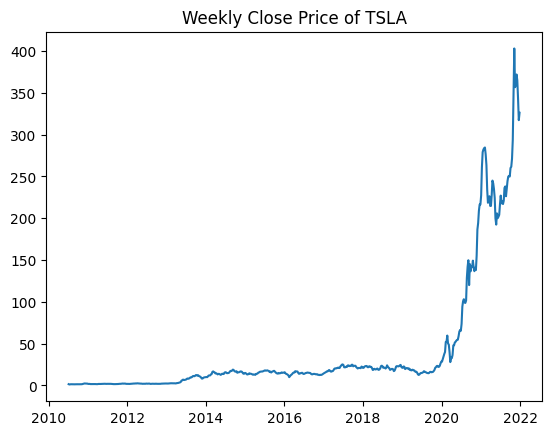

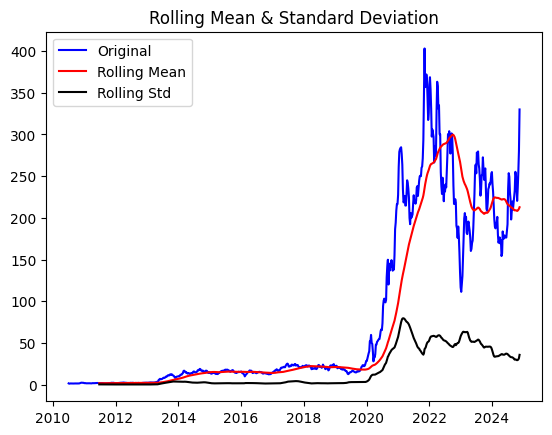

Results of Dickey-Fuller Test:
Test Statistic                  -0.353961
p-value                          0.917507
#Lags Used                      20.000000
Number of Observations Used    730.000000
Critical Value (1%)             -3.439340
Critical Value (5%)             -2.865507
Critical Value (10%)            -2.568883
dtype: float64


In [85]:
# Using Close price for analysis and ARIMA model
ts =train

# Plot the time series data
import matplotlib.pyplot as plt
plt.plot(ts)
plt.title('Weekly Close Price of '+stock)
plt.show()




# Check for stationarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    # Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts_w, 52)

### Staoinarity:
The time series data should be stationary for the model to work. We will check the stationarity of the time series data using the Augmented Dickey-Fuller test. If the data is not stationary, we will difference the data to make it stationary.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data is non-stationary.
From, ADF test p-vlaue=0.99, we can see that the data is non-stationary.

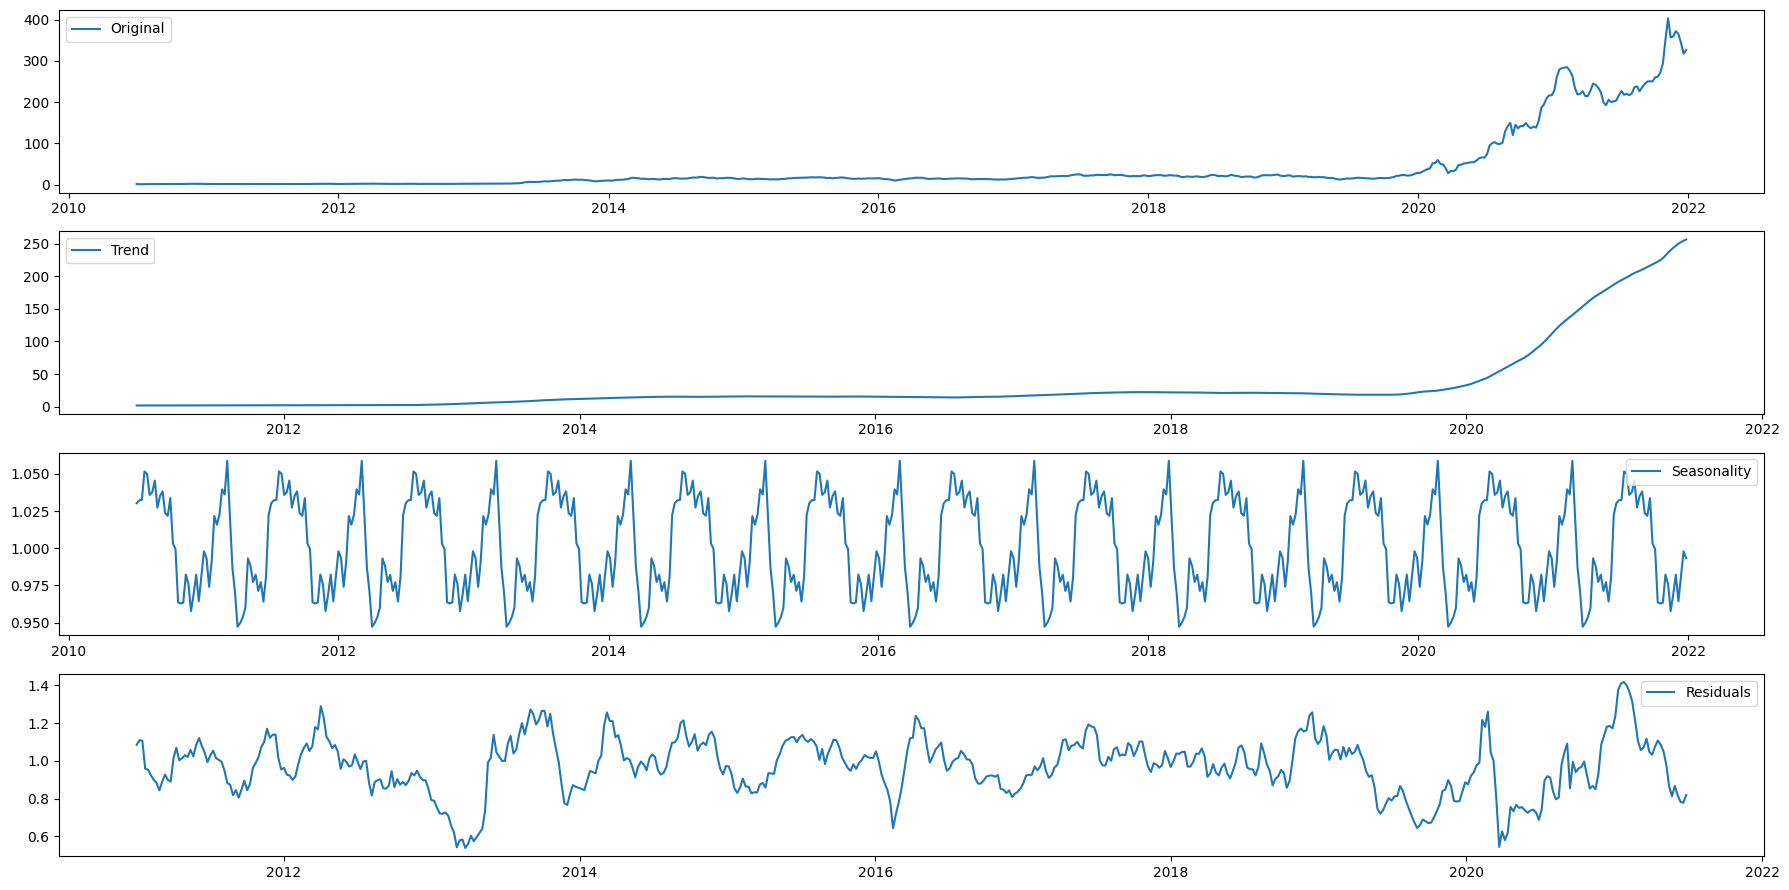

In [86]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decomposition
decomposition = seasonal_decompose(train, model='multiplicative',period=52)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Visualize decomposition
plt.figure(figsize=(18,9))
plt.subplot(411)
plt.plot(train, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

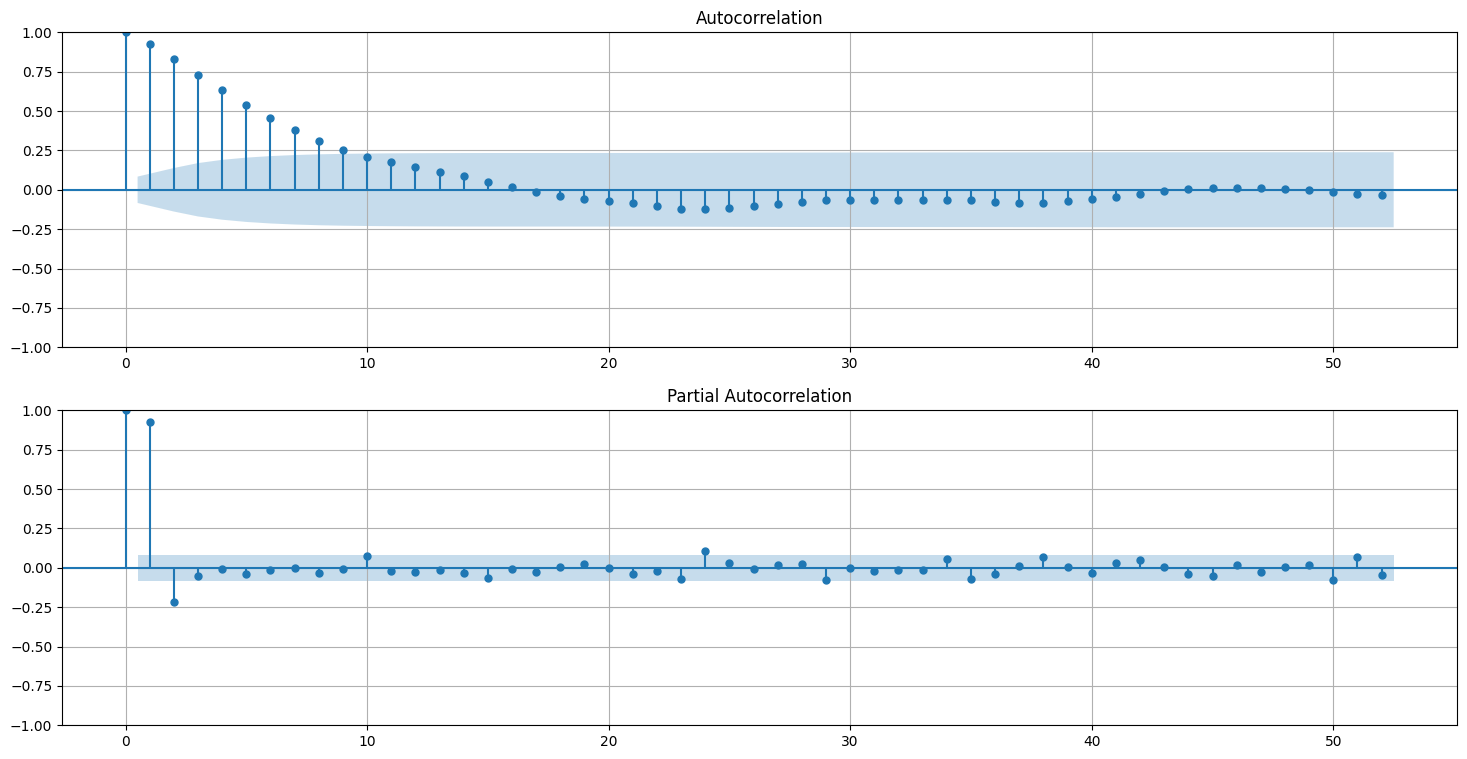

In [87]:
# Import libraries# Import 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Remove Nan values from the residuals
resid = residual.dropna()

# Examine acf and pacf for the smoothed residuals
plt.figure(figsize=(18,9))
plt.subplot(211)
plot_acf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.subplot(212)
plot_pacf(resid, lags=52, ax=plt.gca())
plt.grid()
plt.show()

In [88]:
import pmdarima as pm

# Automatically determine the best ARIMA parameters
model = pm.auto_arima(resid, seasonal=False, stepwise=True, suppress_warnings=True)
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  548
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 822.764
Date:                Sun, 17 Nov 2024   AIC                          -1637.528
Time:                        15:43:35   BIC                          -1620.303
Sample:                    01-02-2011   HQIC                         -1630.796
                         - 06-27-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0846      0.015      5.571      0.000       0.055       0.114
ar.L1          1.1305      0.031     36.608      0.000       1.070       1.191
ar.L2         -0.2176      0.032     -6.835      0.0

In [89]:
# Load libraries
from statsmodels.tsa.arima.model import sarimax
from statsmodels.tsa.arima.model import ARIMA
import time

# Fit optimized ARIMA model:
model = ARIMA(train, order=model.order)
start = time.time() # record start time
model_fit = model.fit()
print('fitting complete after {} seconds'.format(time.time()-start)) # because the process takes time, w

fitting complete after 0.12420415878295898 seconds


/Users/manperumal/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [90]:
# forecast next year (52 cycles)
results = model_fit.forecast(len(test))

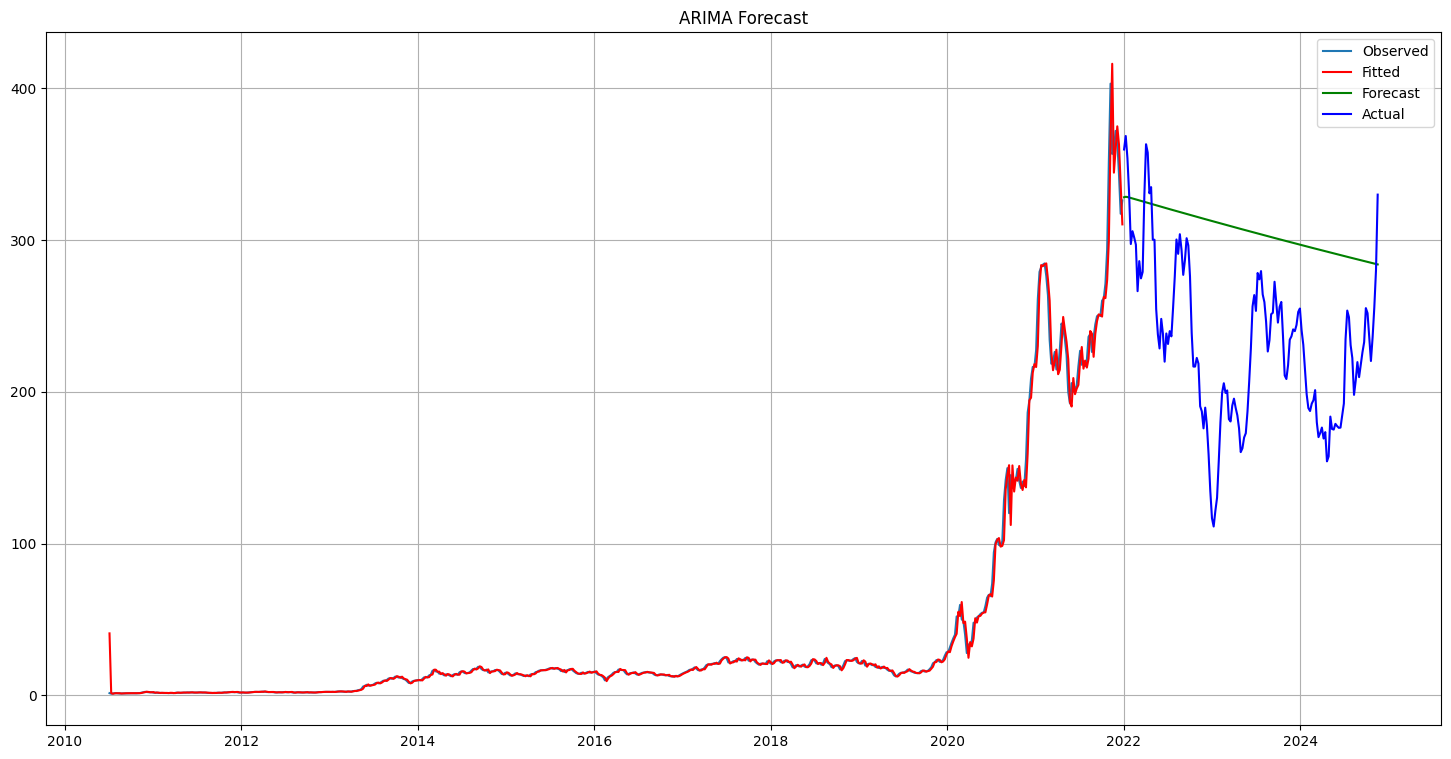

In [91]:
#  Plot forecasts 
plt.figure(figsize=(18,9))
plt.plot(train, label='Observed')
plt.plot(model_fit.fittedvalues, color='red', label='Fitted')
plt.plot(results, color='green', label='Forecast')
plt.plot(test, color='blue', label='Actual')
plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.grid()
plt.show()

In [92]:
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adjusted Close   No. Observations:                  600
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1913.173
Date:                Sun, 17 Nov 2024   AIC                           3834.347
Time:                        15:43:36   BIC                           3851.934
Sample:                    07-04-2010   HQIC                          3841.193
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.8494    659.866      0.062      0.951   -1252.465    1334.163
ar.L1          1.2589      0.010    131.744      0.000       1.240       1.278
ar.L2         -0.2597      0.010    -25.134      0.000      -0.280      -0.239
sigma2        34.0588      0.479     71.130      0.000      33.120      34.997
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):             35131.67
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):             661.83   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""